# Tumor Detection Project
**Objective:** Classify tumors as Malignant (M) or Benign (B) using the Tumor_Detection.csv dataset.


In [5]:
# Basic libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)

# Display settings
%matplotlib inline
sns.set(style='whitegrid')


Load dataset & quick info

In [6]:
# Load the CSV file
df = pd.read_csv('Tumor_Detection.csv')

# Show shape and first rows
print("Shape:", df.shape)
display(df.head())

# Show basic info and missing value check
print("\nInfo:")
display(df.info())
print("\nMissing values per column:")
display(df.isnull().sum())


Shape: (569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se       

None


Missing values per column:


id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Clean data (drop id / unnamed), check duplicates

In [7]:
# Drop identifier column 'id' if present
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)

# Drop any unnamed extra columns (common if CSV has index saved)
unnamed_cols = [c for c in df.columns if 'unnamed' in c.lower()]
if unnamed_cols:
    df.drop(columns=unnamed_cols, inplace=True)

# Check duplicates (optional) and remove if any
print("Duplicate rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)


Duplicate rows: 0


Target encoding and class distribution

In [8]:
# Target: diagnosis (M / B). Encode M=1, B=0
df['diagnosis_encoded'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Show class counts
print("Class distribution:")
display(df['diagnosis'].value_counts())
display(df['diagnosis_encoded'].value_counts())


Class distribution:


diagnosis
B    357
M    212
Name: count, dtype: int64

diagnosis_encoded
0    357
1    212
Name: count, dtype: int64

Exploratory Data Analysis (countplot + correlation heatmap)

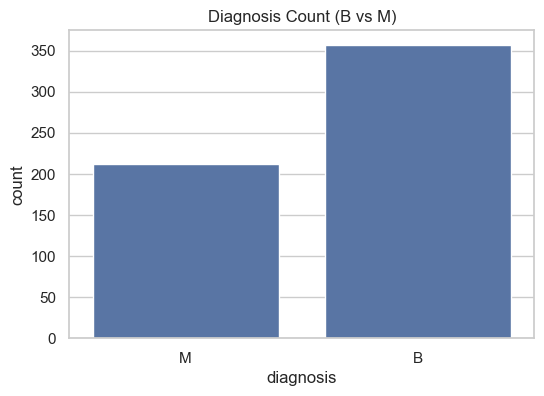

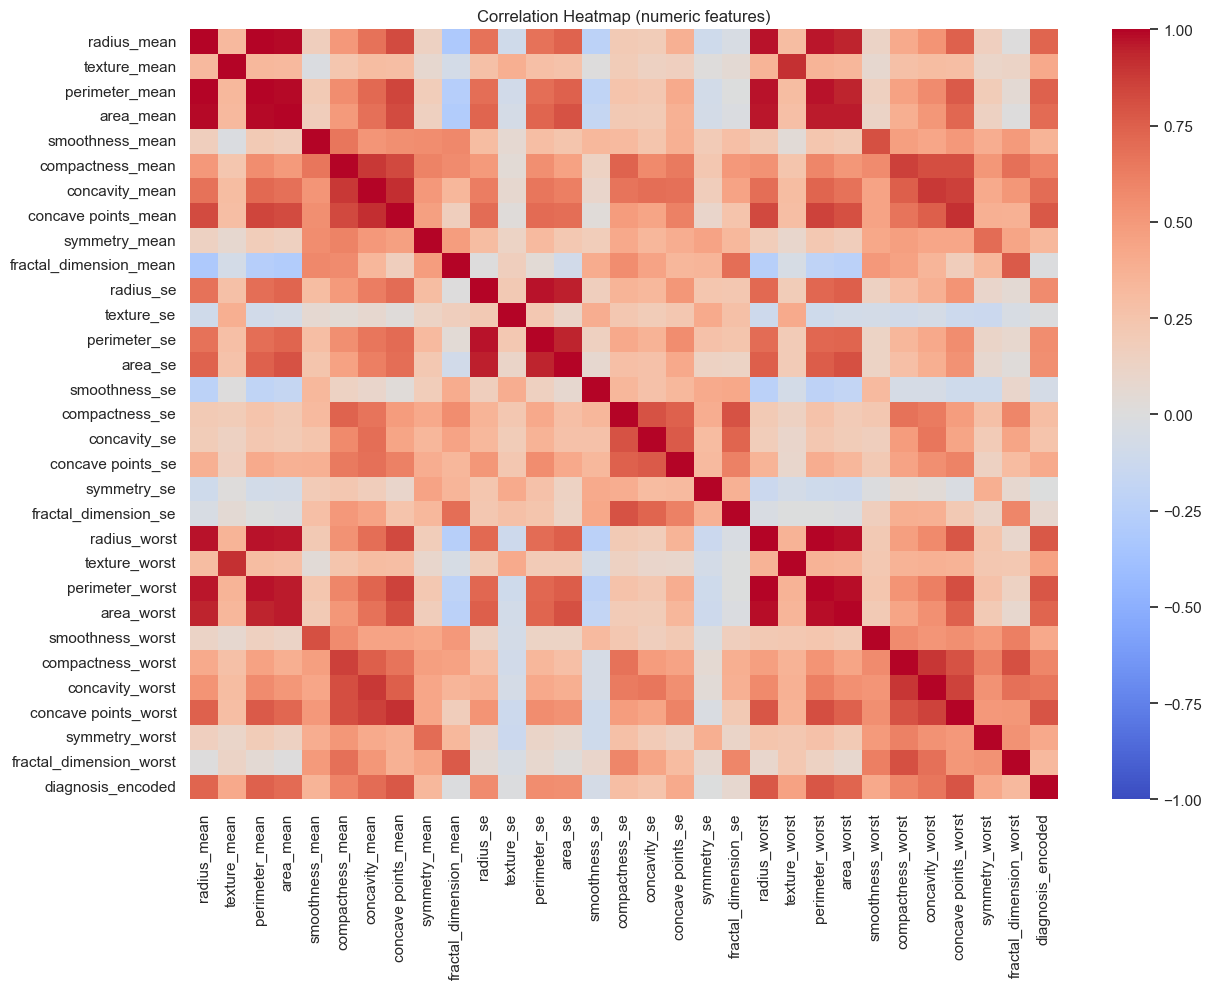

In [9]:
# Count plot for diagnosis
plt.figure(figsize=(6,4))
sns.countplot(x='diagnosis', data=df)
plt.title('Diagnosis Count (B vs M)')
plt.show()

# Correlation heatmap (use numeric features only)
plt.figure(figsize=(14,10))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
plt.title('Correlation Heatmap (numeric features)')
plt.show()


Prepare features (X) and target (y)

In [10]:
# Drop original diagnosis column and keep encoded target
# Select numeric feature columns (exclude diagnosis_encoded)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove target from feature list
if 'diagnosis_encoded' in numeric_cols:
    numeric_cols.remove('diagnosis_encoded')

X = df[numeric_cols]   # features
y = df['diagnosis_encoded']  # target

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (569, 30)
Target shape: (569,)


Train-test split and scaling

In [11]:
# Split into train and test sets (stratify to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Scale features with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train shape: (426, 30) Test shape: (143, 30)


Train Random Forest Classifier

In [12]:
# Create and train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]  # probability for class 1


 Evaluation: accuracy, confusion matrix, classification report

In [13]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", round(acc, 4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Detailed classification report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign (0)', 'Malignant (1)']))


Test Accuracy: 0.965

Confusion Matrix:
 [[90  0]
 [ 5 48]]

Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.95      1.00      0.97        90
Malignant (1)       1.00      0.91      0.95        53

     accuracy                           0.97       143
    macro avg       0.97      0.95      0.96       143
 weighted avg       0.97      0.97      0.96       143



ROC AUC and ROC curve

ROC AUC: 0.9945


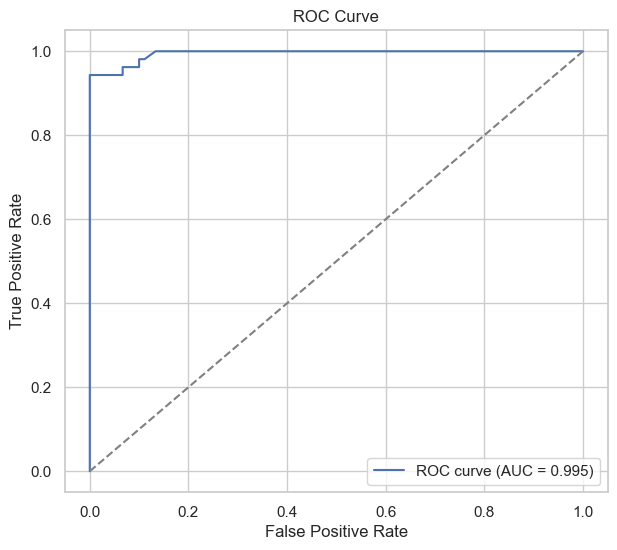

In [14]:
# ROC AUC
auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", round(auc, 4))

# ROC curve plot
fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Feature importances (top features)

Top 10 important features:


area_worst              0.132283
concave points_worst    0.127591
concave points_mean     0.100668
radius_worst            0.093501
perimeter_mean          0.086713
perimeter_worst         0.083703
radius_mean             0.065337
concavity_mean          0.051580
area_mean               0.036159
concavity_worst         0.027264
dtype: float64

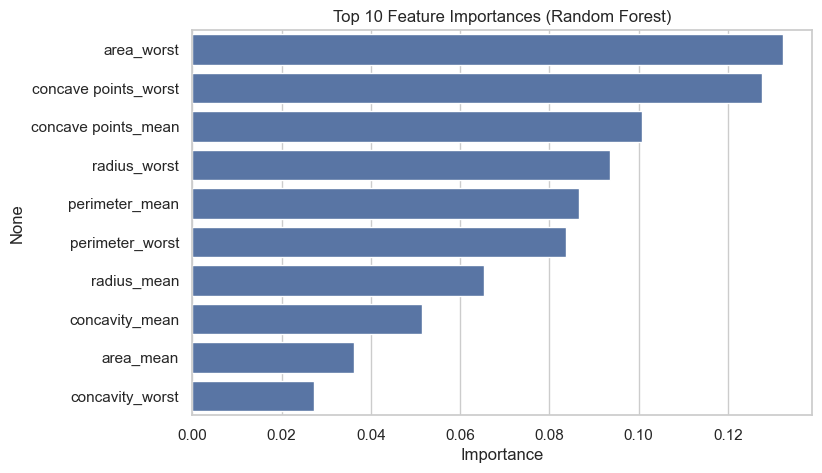

In [15]:
# Feature importance from Random Forest
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=numeric_cols).sort_values(ascending=False)

# Show top 10 features
print("Top 10 important features:")
display(feat_imp.head(10))

# Bar plot of top 10
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.head(10), y=feat_imp.head(10).index)
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.show()


In [16]:
# Optional: save trained model and scaler for future use
import joblib
joblib.dump(rf, 'rf_tumor_model.pkl')
joblib.dump(scaler, 'scaler_tumor.pkl')
print("Model and scaler saved.")


Model and scaler saved.


## Final Notes / Conclusion

- Dataset: 569 samples, numeric tumor features (mean, se, worst) and diagnosis label (M/B).
- Model used: Random Forest Classifier (good baseline for tabular medical data).
- Evaluation: check test Accuracy, Confusion Matrix, Classification Report, ROC-AUC.
